In [1]:
# Import required packages
import torch
import numpy as np
import nflib as nf

from sklearn.datasets import make_moons

from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow, LinearFlow
from nflib.coupling_flows import AffineHalfFlow, MLP_Generator, DimensionMixer
from nflib.res_flow import ResidualFlow, ReLU, LeakyReLU, Swish

##### Linear units are worst

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform

In [4]:
import normflow

In [5]:
# Set up model

# Define flows
K = 16
torch.manual_seed(0)

latent_size = 2
hidden_units = 128
hidden_layers = 3

flows = []
for i in range(K):
    net = normflow.nets.LipschitzMLP([latent_size] + [hidden_units] * (hidden_layers - 1) + [latent_size],
                               init_zeros=True, lipschitz_const=0.9)
#     flows += [nf.flows.Residual(net, reduce_memory=True)]
    flows += [ResidualFlow(2, net, scaler=0.97)]
    flows += [ActNorm(latent_size)]

# Set prior and q0
q0 = MultivariateNormal(torch.zeros(2), torch.eye(2))
    
# Construct flow model
nfm = NormalizingFlow(flows, q0)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)

# Initialize ActNorm
x_np, _ = make_moons(2 ** 9, noise=0.1)
x = torch.tensor(x_np).float().to(device)
_, logprob = nfm.forward(x)

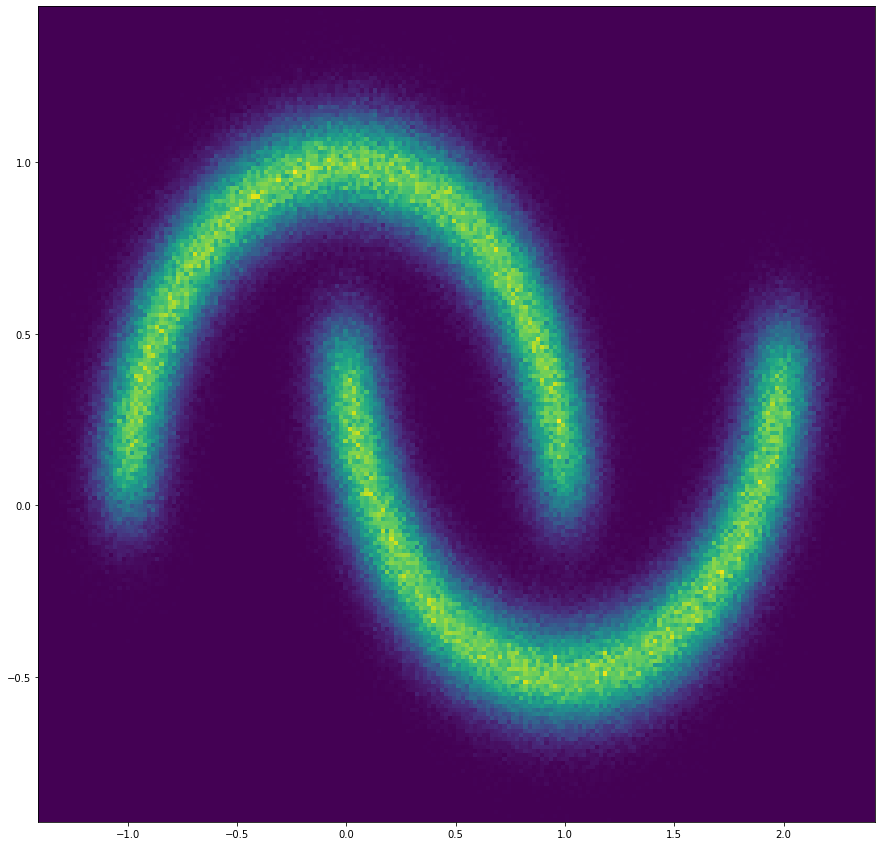

tensor(0) NANs


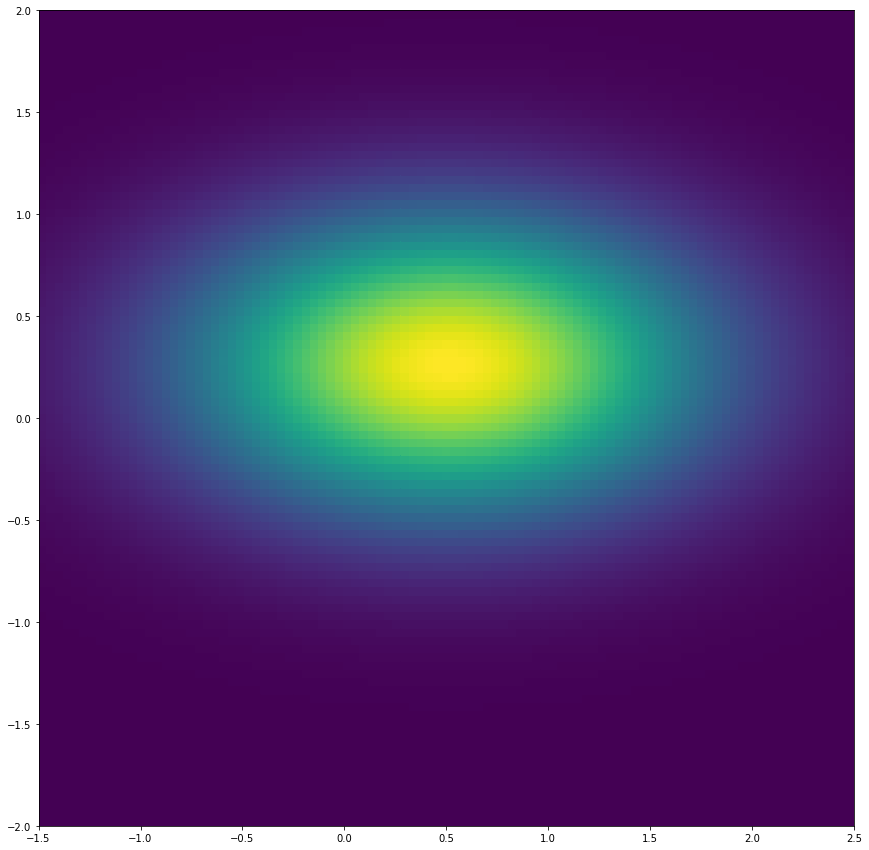

In [6]:
# Plot prior distribution
x_np, _ = make_moons(2 ** 20, noise=0.1)
plt.figure(figsize=(15, 15))
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
plt.show()

# Plot initial posterior distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
_, logDetJ, prior_logP = nfm(zz, True)
log_prob = (logDetJ+prior_logP).to('cpu').view(*xx.shape)

# log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
print(torch.count_nonzero(torch.isnan(prob)), 'NANs')
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

  5%|▍         | 499/10000 [02:10<39:53,  3.97it/s]  

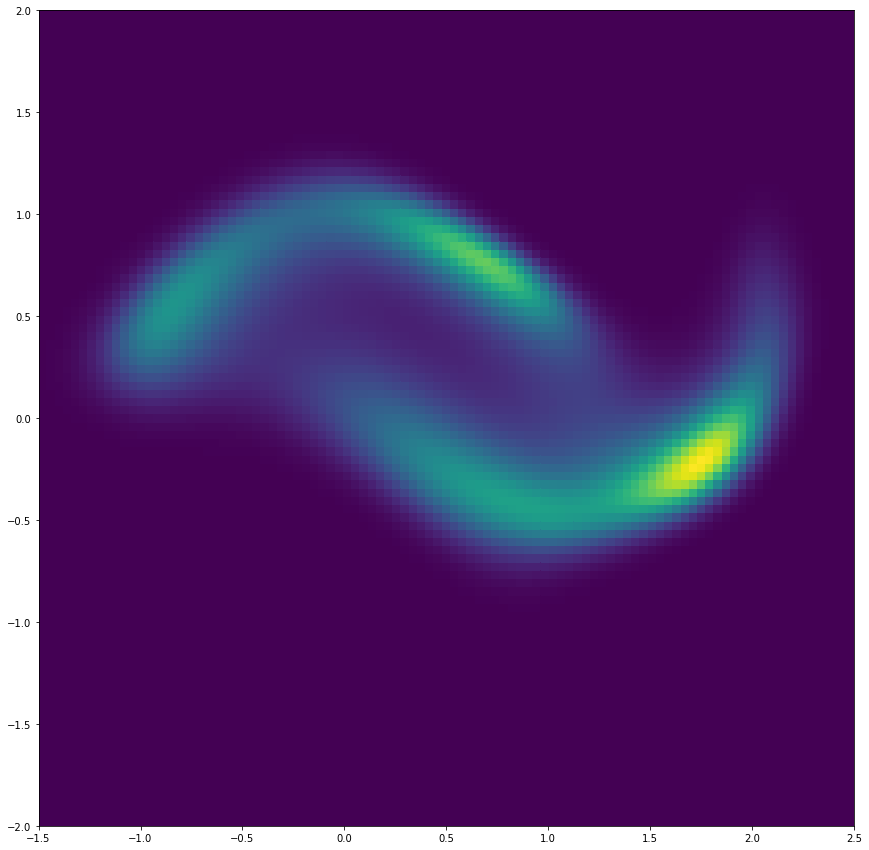

  7%|▋         | 689/10000 [03:19<44:50,  3.46it/s]   


KeyboardInterrupt: 

In [7]:
# Train model
max_iter = 10000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x_np, _ = make_moons(num_samples, noise=0.1)
    x = torch.tensor(x_np).float().to(device)
    
    # Compute loss
    z, logDetJ, prior_logP = nfm.forward(x, True)
    loss = -torch.mean(prior_logP + logDetJ)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    
    nf.res_flow.update_lipschitz(nfm, 5)
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        nfm.eval()
        _, logDetJ, prior_logP = nfm(zz, True)
        log_prob = (logDetJ+prior_logP).to('cpu').view(*xx.shape)

        nfm.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
# if (it + 1) % show_iter == 0:
#     nfm.eval()
#     _, logDetJ, prior_logP = nfm(zz, True)
#     log_prob = (logDetJ+prior_logP).to('cpu').view(*xx.shape)

#     nfm.train()
#     prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
#     prob[torch.isnan(prob)] = 0

#     plt.figure(figsize=(15, 15))
#     plt.pcolormesh(xx, yy, prob.data.numpy())
#     plt.gca().set_aspect('equal', 'box')
#     plt.show()